In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import seaborn as sns
from scipy import stats
import warnings
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
holdout_data = pd.read_csv('/Users/brendanferris/Desktop/kings_county_housing/EDA/kc_house_data_test_features.csv')
census_data = pd.read_excel('/Users/brendanferris/Desktop/kings_county_housing/EDA/extradata.xlsx')
holdout_data.drop('Unnamed: 0', axis=1, inplace=True)

holdout_data.shape

FileNotFoundError: [Errno 2] File b'/Users/brendanferris/Desktop/kings_county_housing/EDA/kc_house_data_test_features.csv' does not exist: b'/Users/brendanferris/Desktop/kings_county_housing/EDA/kc_house_data_test_features.csv'

# Removing Outliers

In [3]:
def clean_beds(dataframe):
    median_beds = dataframe.bedrooms.median()
    dataframe['bedrooms'].values[dataframe['bedrooms'].values > 10] = median_beds
    print('Entries with an abnormal amount of bedrooms have been replaced with {}, the median number of bedrooms in the dataframe. \n'.format(median_beds))

In [4]:
clean_beds(holdout_data)

Entries with an abnormal amount of bedrooms have been replaced with 3.0, the median number of bedrooms in the dataframe. 



# Adding additional Zipcode information

In [5]:
holdout_data = pd.merge(holdout_data, census_data, left_on='zipcode', right_on='zipcode')

# Adding Features

In [6]:
holdout_data['home_age'] =  2015 - holdout_data.yr_built
holdout_data['available_housing'] = holdout_data['total_housing_units'] - holdout_data['occupied_housing_units']

#turning date into datetime so we can extract sale year/month
holdout_data['date'] = pd.to_datetime(holdout_data['date'])

holdout_data['sale_year'] = pd.DatetimeIndex(holdout_data['date']).year
holdout_data['sale_month'] = pd.DatetimeIndex(holdout_data['date']).month
holdout_data.drop(columns='date', inplace=True)

#### Dummy features

In [7]:
waterfront_dummies = pd.get_dummies(holdout_data['waterfront'], prefix='waterf', drop_first=True)
view_dummies = pd.get_dummies(holdout_data['view'], prefix='has_view', drop_first=True)
condition_dummies = pd.get_dummies(holdout_data['condition'], prefix='condition', drop_first=True)
grade_dummies = pd.get_dummies(holdout_data['grade'], prefix='grade', drop_first=True)
month_dummies = pd.get_dummies(holdout_data['sale_month'], prefix='month', drop_first=True)
zip_dummies = pd.get_dummies(holdout_data['zipcode'], prefix='zip', drop_first=True)

In [8]:
holdout_data = holdout_data.drop(['postoffice','id','zipcode','sale_month','waterfront', 'view', 'condition', 'grade'], axis=1)
holdout_data = pd.concat([holdout_data, waterfront_dummies, view_dummies, condition_dummies, grade_dummies, month_dummies, zip_dummies], axis=1)

# Removing Colinear Features

In [9]:
def multicolinear_features(data):
    '''
    input: dataframe
    returns a dataframe of all colinear features in a dataframe.
    '''

    df=data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    df['pairs'] = list(zip(df.level_0, df.level_1))
    df.set_index(['pairs'], inplace = True)
    df.drop(columns=['level_1', 'level_0'], inplace = True)
    df.columns = ['cc']
    return df[(df.cc>.75) & (df.cc <1)]

In [10]:
multicolinear_features(holdout_data)

,cc
pairs,
"(home_age, yr_built)",1.000000
"(yr_built, home_age)",1.000000
"(zip_98003, available_housing)",0.997931
"(available_housing, zip_98003)",0.997931
"(population, occupied_housing_units)",0.930249
"(occupied_housing_units, population)",0.930249
"(sqft_above, sqft_living)",0.906526
"(sqft_living, sqft_above)",0.906526
"(population, owned_household_with_mortgage)",0.863864


In [11]:
holdout_data.drop(['zip_98003',
                    'owned_household_with_mortgage', 
                    'houses_owned_outright',
                    'land_area',
                    'occupied_housing_units',
                    'total_housing_units',
                    'sqft_living', 
                    'condition_3'], axis=1, inplace=True)

In [12]:
multicolinear_features(holdout_data)

,cc
pairs,
"(yr_built, home_age)",1.0
"(home_age, yr_built)",1.0


# Adding poly features

In [13]:
poly_feats = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly_feats.fit_transform(holdout_data)
poly_columns = poly_feats.get_feature_names(holdout_data.columns)
df_poly = pd.DataFrame(poly_data, columns=poly_columns)
df_poly.shape

(4323, 7380)

In [14]:
selected_columns = [
    'bedrooms',
 'bathrooms',
 'sqft_above',
 'sqft_basement',
 'lat',
 'sqft_living15',
 'median_household_income',
 'median_home_value',
 'waterf_1',
 'has_view_4',
 'grade_7',
 'grade_10',
 'grade_11',
 'grade_12',
 'zip_98004',
 'bedrooms^2',
 'bedrooms bathrooms',
 'bedrooms floors',
 'bedrooms sqft_above',
 'bedrooms sqft_basement',
 'bedrooms yr_built',
 'bedrooms lat',
 'bedrooms long',
 'bedrooms sqft_living15',
 'bedrooms median_household_income',
 'bedrooms median_home_value',
 'bedrooms water_area_sq_mile',
 'bedrooms sold_and_unoccupied',
 'bedrooms seasonal_or_rec_use',
 'bedrooms sale_year',
 'bedrooms waterf_1',
 'bedrooms has_view_4',
 'bedrooms grade_7',
 'bedrooms grade_10',
 'bedrooms grade_11',
 'bedrooms grade_12',
 'bedrooms grade_13',
 'bedrooms zip_98004',
 'bathrooms^2',
 'bathrooms floors',
 'bathrooms sqft_above',
 'bathrooms sqft_basement',
 'bathrooms yr_built',
 'bathrooms lat',
 'bathrooms long',
 'bathrooms sqft_living15',
 'bathrooms pop_density',
 'bathrooms median_household_income',
 'bathrooms median_home_value',
 'bathrooms water_area_sq_mile',
 'bathrooms sold_and_unoccupied',
 'bathrooms seasonal_or_rec_use',
 'bathrooms sale_year',
 'bathrooms waterf_1',
 'bathrooms has_view_4',
 'bathrooms grade_7',
 'bathrooms grade_10',
 'bathrooms grade_11',
 'bathrooms grade_12',
 'bathrooms grade_13',
 'bathrooms zip_98004',
 'bathrooms zip_98039',
 'sqft_lot zip_98004',
 'floors sqft_above',
 'floors sqft_basement',
 'floors sqft_living15',
 'floors median_household_income',
 'floors median_home_value',
 'floors sold_and_unoccupied',
 'floors seasonal_or_rec_use',
 'floors waterf_1',
 'floors has_view_4',
 'floors grade_7',
 'floors grade_10',
 'floors grade_11',
 'floors grade_12',
 'floors zip_98004',
 'sqft_above^2',
 'sqft_above sqft_basement',
 'sqft_above yr_built',
 'sqft_above lat',
 'sqft_above long',
 'sqft_above sqft_living15',
 'sqft_above population',
 'sqft_above pop_density',
 'sqft_above median_household_income',
 'sqft_above median_home_value',
 'sqft_above water_area_sq_mile',
 'sqft_above renter_occupied_households',
 'sqft_above sold_and_unoccupied',
 'sqft_above seasonal_or_rec_use',
 'sqft_above home_age',
 'sqft_above sale_year',
 'sqft_above waterf_1',
 'sqft_above has_view_4',
 'sqft_above grade_7',
 'sqft_above grade_10',
 'sqft_above grade_11',
 'sqft_above grade_12',
 'sqft_above grade_13',
 'sqft_above zip_98004',
 'sqft_above zip_98039',
 'sqft_basement^2',
 'sqft_basement yr_built',
 'sqft_basement lat',
 'sqft_basement long',
 'sqft_basement sqft_living15',
 'sqft_basement pop_density',
 'sqft_basement median_household_income',
 'sqft_basement median_home_value',
 'sqft_basement water_area_sq_mile',
 'sqft_basement renter_occupied_households',
 'sqft_basement sold_and_unoccupied',
 'sqft_basement seasonal_or_rec_use',
 'sqft_basement home_age',
 'sqft_basement sale_year',
 'sqft_basement waterf_1',
 'sqft_basement has_view_4',
 'sqft_basement grade_11',
 'yr_built sqft_living15',
 'yr_built median_household_income',
 'yr_built median_home_value',
 'yr_built waterf_1',
 'yr_built has_view_4',
 'yr_built grade_7',
 'yr_built grade_10',
 'yr_built grade_11',
 'yr_built grade_12',
 'yr_built zip_98004',
 'lat^2',
 'lat long',
 'lat sqft_living15',
 'lat median_household_income',
 'lat median_home_value',
 'lat sale_year',
 'lat waterf_1',
 'lat has_view_4',
 'lat grade_7',
 'lat grade_10',
 'lat grade_11',
 'lat grade_12',
 'lat zip_98004',
 'long sqft_living15',
 'long median_household_income',
 'long median_home_value',
 'long waterf_1',
 'long has_view_4',
 'long grade_7',
 'long grade_10',
 'long grade_11',
 'long grade_12',
 'long zip_98004',
 'sqft_living15^2',
 'sqft_living15 population',
 'sqft_living15 pop_density',
 'sqft_living15 median_household_income',
 'sqft_living15 median_home_value',
 'sqft_living15 water_area_sq_mile',
 'sqft_living15 renter_occupied_households',
 'sqft_living15 sold_and_unoccupied',
 'sqft_living15 seasonal_or_rec_use',
 'sqft_living15 sale_year',
 'sqft_living15 waterf_1',
 'sqft_living15 has_view_4',
 'sqft_living15 grade_7',
 'sqft_living15 grade_10',
 'sqft_living15 grade_11',
 'sqft_living15 grade_12',
 'sqft_living15 zip_98004',
 'sqft_lot15 pop_density',
 'sqft_lot15 zip_98004',
 'population median_home_value',
 'population waterf_1',
 'population has_view_4',
 'population grade_7',
 'population grade_10',
 'population grade_11',
 'population grade_12',
 'population zip_98004',
 'pop_density median_home_value',
 'pop_density seasonal_or_rec_use',
 'pop_density has_view_4',
 'pop_density grade_10',
 'pop_density grade_11',
 'pop_density grade_12',
 'pop_density zip_98004',
 'median_household_income^2',
 'median_household_income median_home_value',
 'median_household_income water_area_sq_mile',
 'median_household_income sold_and_unoccupied',
 'median_household_income seasonal_or_rec_use',
 'median_household_income sale_year',
 'median_household_income waterf_1',
 'median_household_income has_view_4',
 'median_household_income grade_7',
 'median_household_income grade_10',
 'median_household_income grade_11',
 'median_household_income grade_12',
 'median_household_income zip_98004',
 'median_home_value^2',
 'median_home_value water_area_sq_mile',
 'median_home_value sold_and_unoccupied',
 'median_home_value seasonal_or_rec_use',
 'median_home_value sale_year',
 'median_home_value waterf_1',
 'median_home_value has_view_4',
 'median_home_value grade_9',
 'median_home_value grade_10',
 'median_home_value grade_11',
 'median_home_value grade_12',
 'median_home_value zip_98004',
 'water_area_sq_mile grade_11',
 'water_area_sq_mile grade_12',
 'water_area_sq_mile zip_98004',
 'renter_occupied_households has_view_4',
 'renter_occupied_households grade_10',
 'renter_occupied_households grade_11',
 'renter_occupied_households grade_12',
 'renter_occupied_households zip_98004',
 'sold_and_unoccupied seasonal_or_rec_use',
 'sold_and_unoccupied waterf_1',
 'sold_and_unoccupied has_view_4',
 'sold_and_unoccupied grade_10',
 'sold_and_unoccupied grade_11',
 'sold_and_unoccupied grade_12',
 'sold_and_unoccupied zip_98004',
 'seasonal_or_rec_use grade_10',
 'seasonal_or_rec_use grade_11',
 'seasonal_or_rec_use grade_12',
 'seasonal_or_rec_use zip_98004',
 'home_age grade_10',
 'home_age grade_11',
 'available_housing waterf_1',
 'available_housing has_view_4',
 'available_housing grade_12',
 'available_housing zip_98004',
 'sale_year waterf_1',
 'sale_year has_view_4',
 'sale_year grade_7',
 'sale_year grade_10',
 'sale_year grade_11',
 'sale_year grade_12',
 'sale_year zip_98004',
 'waterf_1^2',
 'has_view_4^2',
 'grade_7^2',
 'grade_10^2',
 'grade_11^2',
 'grade_12^2',
 'zip_98004^2'
]

# Predicting on the holdout

In [15]:
holdout_data = df_poly[selected_columns]

In [16]:
import pickle

final_model = pickle.load(open('final_model.pickle', 'rb'))

In [17]:
preds = final_model.predict(holdout_data)

In [18]:
predictions = pd.DataFrame(preds, columns=['holdout_pred'])

predictions.to_csv('housing_pred_Brendan_Ferris.csv')

In [19]:
predictions.sort_values(by='holdout_pred',ascending=True)

,holdout_pred
4203,7.709202e+04
3564,9.319973e+04
3846,1.060229e+05
3554,1.143769e+05
3562,1.280420e+05
...,...
633,3.182331e+06
1349,3.239482e+06
4306,3.716574e+06
1896,3.827836e+06


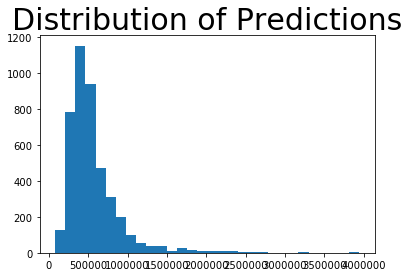

In [20]:
plt.hist(preds, bins=30);
plt.title('Distribution of Predictions', size=30);